# Music genre prediction

**Описание задачи**

Вы сотрудник Отдела Data Science популярного музыкального стримингового сервиса. Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Ваши коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Ваша задача - разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

В ходе работы пройдите все основные этапы полноценного исследования:

*  загрузка и ознакомление с данными
*  предварительная обработка
*  полноценный разведочный анализ
*  разработка новых синтетических признаков
*  проверка на мультиколлинеарность
*  отбор финального набора обучающих признаков
*  выбор и обучение моделей
*  итоговая оценка качества предсказания лучшей модели
*  анализ важности ее признаков

**ВАЖНО**  
Необходимо реализовать решение с использованием технологии `pipeline` (из библиотеки `sklearn`)

**ОЖИДАЕМЫЙ РЕЗУЛЬТАТ**

* Оформленный репозиторий на GitHub (ноутбук с исследованием + код приложения)
* Развернутое web-приложение (с использованием библиотеки Streamlit)

## Участники проекта, репозиторий, приложение

...

...

## Импорт библиотек, установка констант

In [184]:
%%capture
!pip install catboost -q

In [185]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier

In [186]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

In [187]:
TRAIN = "https://www.dropbox.com/scl/fi/5zy935lqpaqr9lat76ung/music_genre_train.csv?rlkey=ccovu9ml8pfi9whk1ba26zdda&dl=1"
TEST = "https://www.dropbox.com/scl/fi/o6mvsowpp9r3k2lejuegt/music_genre_test.csv?rlkey=ac14ydue0rzlh880jwj3ebum4&dl=1"

In [188]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка и обзор данных

In [189]:
train = pd.read_csv(TRAIN)
test = pd.read_csv(TEST)

In [190]:
train

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.48000,0.670,182653.0,0.351,0.017600,D,0.1150,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.24300,0.452,187133.0,0.670,0.000051,A,0.1080,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.22800,0.454,173448.0,0.804,0.000000,E,0.1810,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.05580,0.847,255987.0,0.873,0.000003,G#,0.3250,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.22700,0.742,195333.0,0.575,0.000002,C,0.1760,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20389,47396.0,O Pato,0.71900,0.725,-1.0,0.483,0.000000,NaN,0.0797,-13.314,Minor,0.0438,87.413,4-Apr,0.942,Jazz
20390,44799.0,Mt. Washington,0.19000,0.482,198933.0,0.362,0.005620,F#,0.0913,-10.358,Minor,0.0299,76.879,4-Apr,0.174,Rock
20391,33350.0,Original Prankster,0.00061,0.663,220947.0,0.886,0.000025,D,0.2840,-4.149,Major,0.0358,146.803,4-Apr,0.942,Alternative
20392,77920.0,4Peat,0.00310,0.914,162214.0,0.515,0.000000,C#,0.1050,-9.934,Major,0.3560,150.016,4-Apr,0.215,Rap


**Описание полей данных**

`instance_id` - уникальный идентификатор трека  
`track_name` - название трека  
`acousticness` - акустичность  
`danceability` - танцевальность  
`duration_ms` -продолжительность в милисекундах  
`energy` - энергичность  
`instrumentalness` - инструментальность  
`key` - тональность  
`liveness` - привлекательность  
`loudness` - громкость  
`mode` - наклонение  
`speechiness` - выразительность  
`tempo` - темп  
`obtained_date` - дата загрузки в сервис  
`valence` - привлекательность произведения для пользователей сервиса  
`music_genre` - музыкальный жанр

## Предварительная обработка данных

In [191]:
# Удалим ненужные столбцы 'track_name' и 'obtained_date', так как они не добавляют полезной информации для предсказания жанра
train.drop(columns=['track_name', 'obtained_date'], inplace=True)
test.drop(columns=['track_name', 'obtained_date'], inplace=True)

In [192]:
# Разделим категории и числовые столбцы для обработки пропусков
categorical_features = ['key', 'mode']
numeric_features = train.columns.difference(categorical_features + ['instance_id', 'music_genre'])

In [193]:
# Заполним пропуски в категориальных столбцах модой (наиболее частое значение)
for col in categorical_features:
    train[col].fillna(train[col].mode()[0], inplace=True)
    test[col].fillna(train[col].mode()[0], inplace=True)


C:\Users\Yar435\AppData\Local\Temp\ipykernel_22964\4088099330.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0], inplace=True)
C:\Users\Yar435\AppData\Local\Temp\ipykernel_22964\4088099330.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



In [194]:
# Заполним пропуски в числовых столбцах медианными значениями
train[numeric_features] = train[numeric_features].fillna(train[numeric_features].median())
test[numeric_features] = test[numeric_features].fillna(test[numeric_features].median())


# numeric_features_minus = numeric_features.drop('duration_ms')
# train[numeric_features_minus] = train[numeric_features_minus].fillna(train[numeric_features].median())
# test[numeric_features_minus] = test[numeric_features_minus].fillna(test[numeric_features].median())
#
# Ttrain_dur = train[train['duration_ms'] != -1].copy().drop(['key', 'mode', 'music_genre'], axis=1)
# Ttest_dur = test[test['duration_ms'] != -1].copy().drop(['key', 'mode'], axis=1)
#
# duration_plus_median_train = Ttrain_dur[Ttrain_dur['duration_ms'] != -1].median()
# duration_plus_median_trtest = Ttest_dur[Ttest_dur['duration_ms'] != -1].median()
#
# train['duration_ms'].mask(train['duration_ms'] == -1.0, duration_plus_median_train, inplace=True)
# test['duration_ms'].mask(test['duration_ms'] == -1.0, duration_plus_median_trtest, inplace=True)
#
# train['duration_ms'] = train['duration_ms'].fillna(Ttrain_dur[train['duration_ms'] != -1].median())
# test['duration_ms'] = test['duration_ms'].fillna(Ttest_dur[test['duration_ms'] != -1].median())



In [195]:
train.head()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,25143.0,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,0.450,Country
1,26091.0,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,0.539,Rock
2,87888.0,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,0.344,Alternative
3,77021.0,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,0.966,Hip-Hop
4,20852.0,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,0.583,Alternative


In [196]:
# Кодируем категориальные переменные с помощью OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_train = pd.DataFrame(encoder.fit_transform(train[['key', 'mode']]), columns=encoder.get_feature_names_out(['key', 'mode']))
encoded_test = pd.DataFrame(encoder.transform(test[['key', 'mode']]), columns=encoder.get_feature_names_out(['key', 'mode']))

In [197]:
# Добавляем закодированные столбцы к основным данным и удаляем исходные переменные
train = train.drop(columns=['key', 'mode']).join(encoded_train)
test = test.drop(columns=['key', 'mode']).join(encoded_test)

In [198]:
# Масштабирование числовых признаков
scaler = StandardScaler()

train[numeric_features] = scaler.fit_transform(train[numeric_features])
test[numeric_features] = scaler.transform(test[numeric_features])

In [199]:
# Разделим тренировочные данные на тренировочную и валидационную выборки
X = train.drop(columns=['instance_id', 'music_genre'])
y = train['music_genre']

In [200]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [201]:
# Подготовим тестовые данные (пример для использования в будущем)
X_test = test.drop(columns=['instance_id'])

## Разведочный анализ

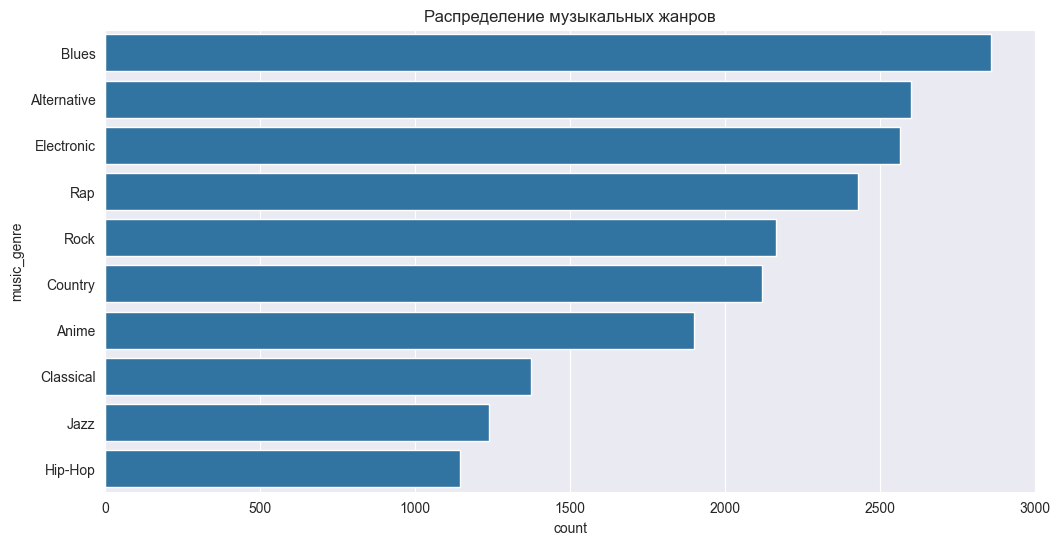

In [202]:
# Анализ целевой переменной (music_genre)
plt.figure(figsize=(12, 6))
sns.countplot(y=train['music_genre'], order=train['music_genre'].value_counts().index)
plt.title('Распределение музыкальных жанров')
plt.show()

<Figure size 1600x1000 with 0 Axes>

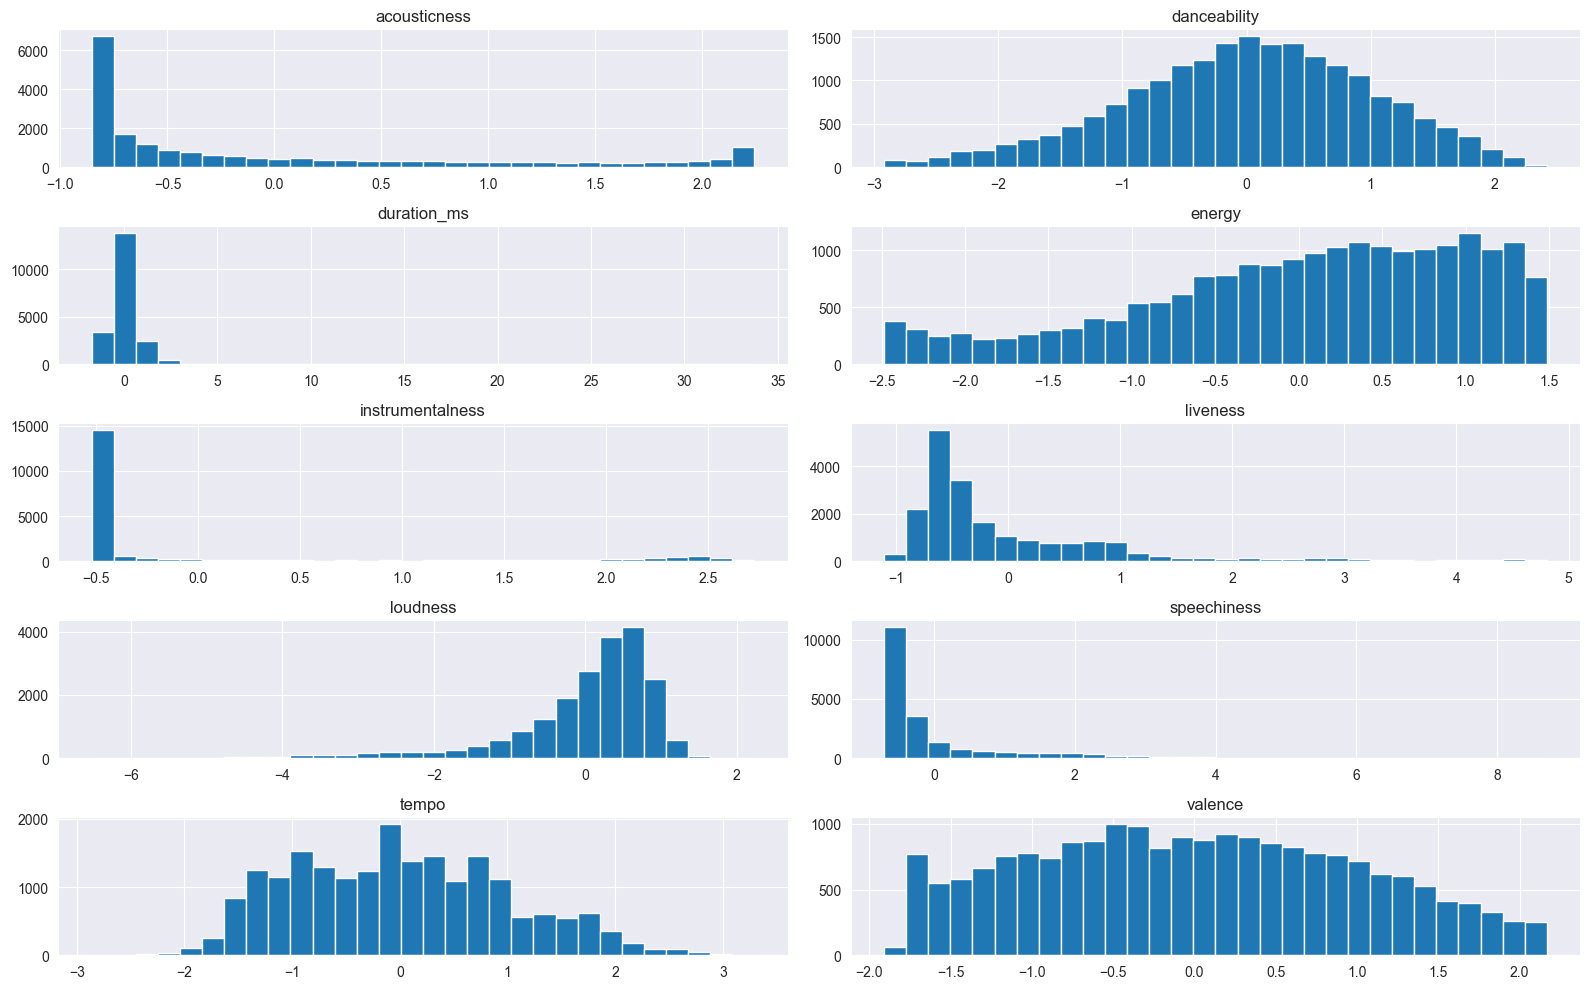

In [203]:
numerical_features = ['acousticness', 'danceability', 'duration_ms',
                      'energy', 'instrumentalness', 'liveness',
                      'loudness', 'speechiness', 'tempo', 'valence']

plt.figure(figsize=(16, 10))
train[numerical_features].hist(bins=30, figsize=(16, 10), layout=(5, 2))
plt.tight_layout()
plt.show()

In [204]:
# from scipy import stats
# from sklearn.preprocessing import PowerTransformer

# pt = PowerTransformer(method='yeo-johnson')
#
# # stats.boxcox(train['acousticness'])

# Не похоже с log
# plt.hist(train['acousticness'], bins=70)
# plt.show()

# # Берем
# plt.hist(np.sqrt(train['danceability']), bins=70)
# plt.show()
#
# # Берем
# plt.hist(np.log(train['duration_ms']), bins=70)
# plt.show()
#
# # Not log
# plt.hist(train['energy'], bins=70)
# plt.show()
#
# # Not log(mb voobshe ne brat)
# plt.hist(train['instrumentalness'], bins=70)
# plt.show()
#
# # Почти(Norm)
# plt.hist(np.log(train['liveness']), bins=70)
# plt.show()
#
# # sqrt/log(luchshe bez vsego)
# plt.hist(train['loudness'], bins=70)
# plt.show()
#
# # + Berem
# plt.hist(np.log(train['speechiness']), bins=70)
# plt.show()
#
# # Больше скрт, чем лог (da +)
# plt.hist(np.sqrt(train['tempo']), bins=70)
# plt.show()
#
# # Baza
# plt.hist(train['valence'], bins=70)
# plt.show()

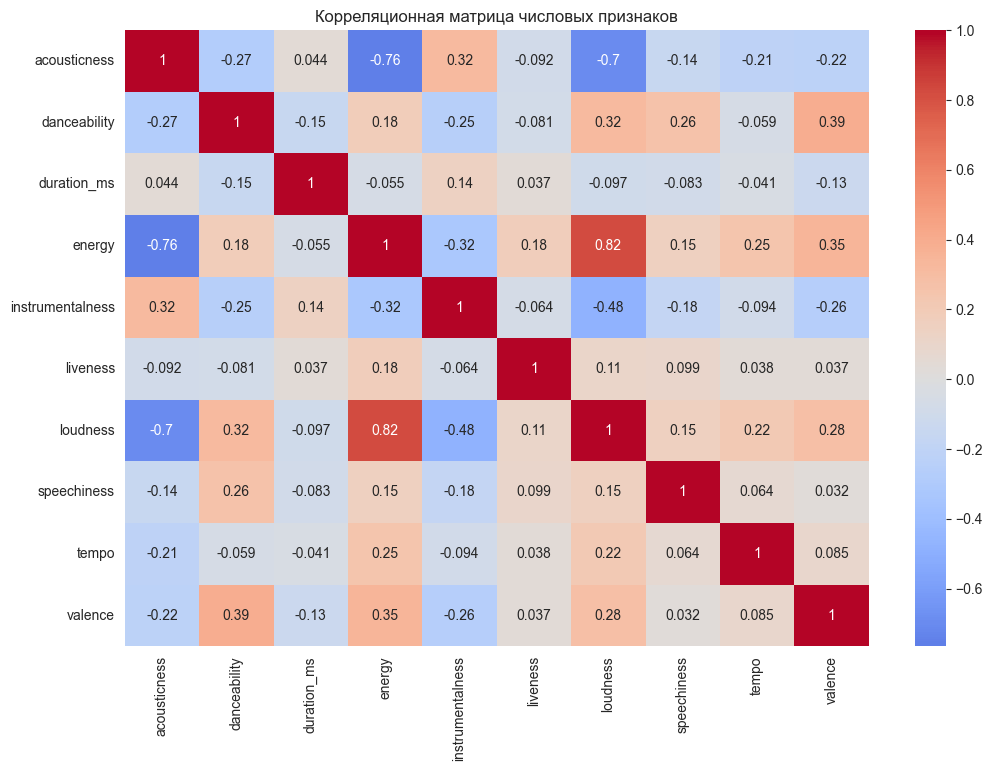

In [205]:
# Корреляционная матрица
plt.figure(figsize=(12, 8))
corr_matrix = train[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица числовых признаков')
plt.show()

In [206]:
# 4. Анализ категориальных признаков
# all_features = test.columns.values.tolist()
# del all_features[0:11]
# categorical_features = all_features
#
# for feature in categorical_features:
#     plt.figure(figsize=(10, 4))
#     sns.countplot(x=train[feature], order=train[feature].value_counts().index)
#     plt.title(f'Распределение признака {feature}')
#     plt.show()

C:\Users\Yar435\AppData\Local\Temp\ipykernel_22964\291403994.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='music_genre', y=feature, data=train, palette="Set3")


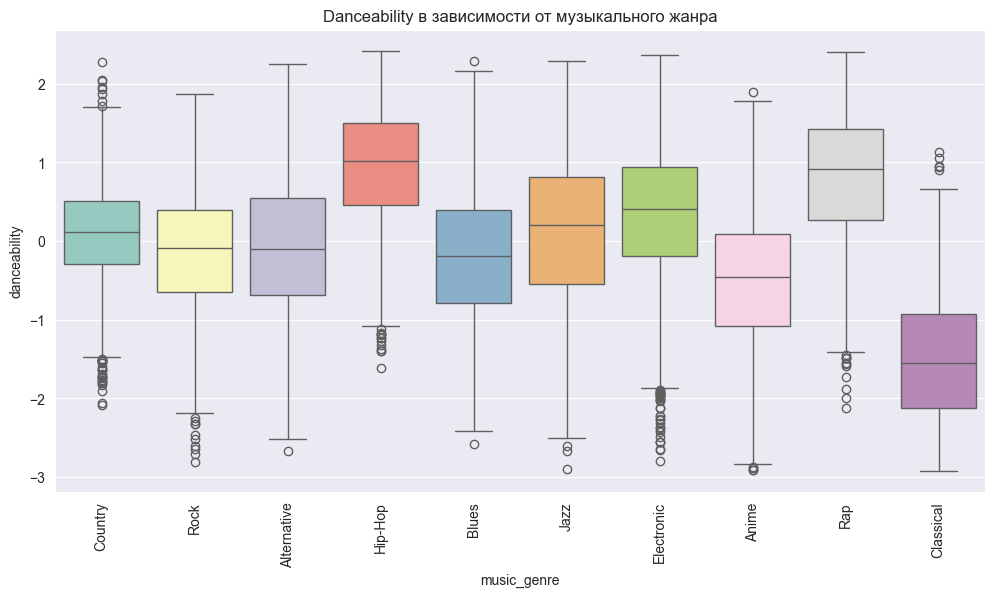

C:\Users\Yar435\AppData\Local\Temp\ipykernel_22964\291403994.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='music_genre', y=feature, data=train, palette="Set3")


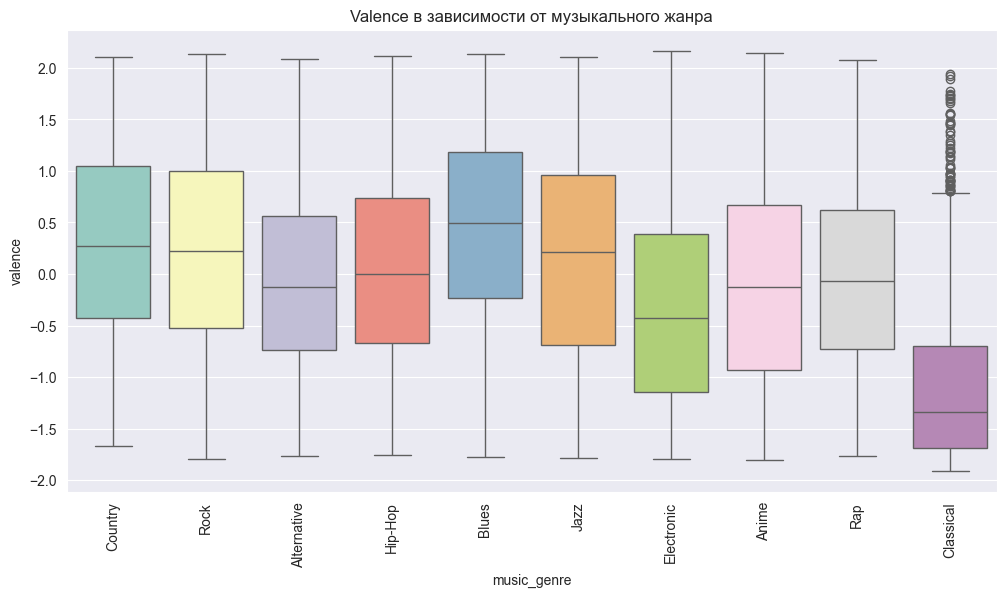

In [207]:
# 5. Взаимосвязи между переменными
# Возьмем два примера - акустичность (acousticness) и танцевальность (danceability) в зависимости от жанра
for feature in ['danceability', 'valence']:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='music_genre', y=feature, data=train, palette="Set3")
    plt.xticks(rotation=90)
    plt.title(f'{feature.title()} в зависимости от музыкального жанра')
    plt.show()

## Работа с признаками

In [208]:
selected_features = ['acousticness', 'danceability', 'energy','instrumentalness', 'liveness',
                     'loudness', 'speechiness', 'tempo', 'valence', 'duration_ms'] + train.columns[train.columns.str.contains('^key')].tolist() + train.columns[train.columns.str.contains('^mode')].tolist()
#

X = train[selected_features]
y = train['music_genre']

In [209]:
X.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms,...,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Major,mode_Minor
0,0.638041,0.628397,-1.091727,-0.464571,-0.501027,-1.507151,-0.460968,-0.649240,-0.059937,-0.297671,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.098818,-0.639832,0.178018,-0.521829,-0.543009,0.029274,-0.574543,-0.260911,0.305745,-0.262319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.145455,-0.628197,0.711391,-0.521995,-0.105197,0.605115,2.861357,-1.327213,-0.495469,-0.370308,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.680843,1.658105,0.986038,-0.521984,0.758431,0.681481,-0.112057,-0.163355,2.060197,0.281014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,-0.148564,1.047261,-0.200119,-0.521989,-0.135185,0.546021,-0.436411,-1.476272,0.486531,-0.197612,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Выбор и обучение моделей

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

In [120]:
# 1. Логистическая регрессия
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_val)
print("Логистическая регрессия")
print("Точность: ", accuracy_score(y_val, y_pred_log_reg))
print(classification_report(y_val, y_pred_log_reg))

Логистическая регрессия
Точность:  0.4055697195528535
              precision    recall  f1-score   support

 Alternative       0.25      0.27      0.26       651
       Anime       0.29      0.17      0.21       475
       Blues       0.38      0.51      0.44       715
   Classical       0.76      0.80      0.78       343
     Country       0.33      0.50      0.40       530
  Electronic       0.58      0.52      0.55       641
     Hip-Hop       0.17      0.00      0.01       286
        Jazz       0.41      0.24      0.30       310
         Rap       0.45      0.73      0.56       607
        Rock       0.21      0.09      0.13       541

    accuracy                           0.41      5099
   macro avg       0.38      0.38      0.36      5099
weighted avg       0.38      0.41      0.38      5099



In [121]:
# 2. Случайный лес
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_val)
print("Случайный лес")
print("Точность: ", accuracy_score(y_val, y_pred_rf))
print(classification_report(y_val, y_pred_rf))

Случайный лес
Точность:  0.4634242008236909
              precision    recall  f1-score   support

 Alternative       0.31      0.27      0.29       651
       Anime       0.53      0.44      0.48       475
       Blues       0.43      0.59      0.50       715
   Classical       0.77      0.83      0.80       343
     Country       0.44      0.56      0.49       530
  Electronic       0.59      0.66      0.62       641
     Hip-Hop       0.17      0.05      0.08       286
        Jazz       0.42      0.20      0.27       310
         Rap       0.47      0.69      0.56       607
        Rock       0.20      0.09      0.12       541

    accuracy                           0.46      5099
   macro avg       0.43      0.44      0.42      5099
weighted avg       0.43      0.46      0.44      5099



In [122]:
# 3. Support Vector Machine
from sklearn.svm import SVC
model = SVC()
model.fit(X_train, y_train)
y_pred_rf = model.predict(X_val)
print("Support Vector Machine")
print("Точность: ", accuracy_score(y_val, y_pred_rf))
print(classification_report(y_val, y_pred_rf))

Support Vector Machine
Точность:  0.451068837026868
              precision    recall  f1-score   support

 Alternative       0.29      0.35      0.31       651
       Anime       0.52      0.38      0.44       475
       Blues       0.42      0.58      0.49       715
   Classical       0.75      0.84      0.79       343
     Country       0.39      0.52      0.45       530
  Electronic       0.60      0.55      0.58       641
     Hip-Hop       0.00      0.00      0.00       286
        Jazz       0.46      0.22      0.30       310
         Rap       0.47      0.77      0.58       607
        Rock       0.19      0.05      0.08       541

    accuracy                           0.45      5099
   macro avg       0.41      0.43      0.40      5099
weighted avg       0.41      0.45      0.42      5099



In [123]:
# 4. Градиентный бустинг
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)
y_pred_gb = gb_clf.predict(X_val)
print("Градиентный бустинг")
print("Точность: ", accuracy_score(y_val, y_pred_gb))
print(classification_report(y_val, y_pred_gb))

Градиентный бустинг
Точность:  0.4747989801921946
              precision    recall  f1-score   support

 Alternative       0.33      0.31      0.32       651
       Anime       0.53      0.44      0.48       475
       Blues       0.42      0.57      0.49       715
   Classical       0.78      0.80      0.79       343
     Country       0.44      0.58      0.50       530
  Electronic       0.62      0.64      0.63       641
     Hip-Hop       0.25      0.07      0.11       286
        Jazz       0.40      0.26      0.32       310
         Rap       0.51      0.72      0.60       607
        Rock       0.27      0.13      0.17       541

    accuracy                           0.47      5099
   macro avg       0.45      0.45      0.44      5099
weighted avg       0.45      0.47      0.45      5099



In [124]:
# Подбор гиперпараметров для лучшей модели(для GBC)
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 4, 5],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'subsample': [0.8, 0.9, 1.0],
#     'max_features': ['auto', 'sqrt', 'log2']
# }
#
# grid_search = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')
# grid_search.fit(X_train, y_train)
#
# best_model = grid_search.best_estimator_
# y_pred_best = best_model.predict(X_val)
#
# best_estimator = grid_search.best_estimator_
# best_score = grid_search.best_score_
# print("Best estimator:", best_estimator)
# print("Best score:", best_score)
# print("Подбор гиперпараметров для Градиентного бустинга")
# print("Точность: ", accuracy_score(y_val, y_pred_best))
# print(classification_report(y_val, y_pred_best))


In [210]:
# 4. Градиентный бустинг(Улучшенный)
gb_clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
)
gb_clf.fit(X_train, y_train)
y_pred_gb = gb_clf.predict(X_val)
print("Градиентный бустинг")
print("Точность: ", accuracy_score(y_val, y_pred_gb))
print(classification_report(y_val, y_pred_gb))

Градиентный бустинг
Точность:  0.4749950970778584
              precision    recall  f1-score   support

 Alternative       0.33      0.30      0.31       651
       Anime       0.55      0.44      0.49       475
       Blues       0.42      0.59      0.49       715
   Classical       0.80      0.82      0.81       343
     Country       0.44      0.57      0.50       530
  Electronic       0.62      0.66      0.64       641
     Hip-Hop       0.17      0.04      0.07       286
        Jazz       0.42      0.25      0.32       310
         Rap       0.50      0.72      0.59       607
        Rock       0.24      0.11      0.15       541

    accuracy                           0.47      5099
   macro avg       0.45      0.45      0.44      5099
weighted avg       0.45      0.47      0.45      5099



## Оценка качества

## Анализ важности признаков модели